# 1. Post processing
`gmx trjconv -f ../step7_1.xtc -o center.xtc -center -pbc mol -s ../step6.0_minimization.tpr -n index.ndx -tu ns -dt 0.05`
- Group for centering: C-alpha_&_r_14_chain1
- Group for output: System

`gmx trjconv -f center.xtc  -o traj-fit-nodt.xtc -s ../step6.0_minimization.tpr -fit rot+trans -tu ns -dt 0.05 -n index.ndx`
- Group for least squares fit: C-alpha_&_r_1-32
- Group for output: System

`gmx trjconv -f ../step7_1.xtc  -o traj-fit-nodt.pdb -s ../step6.0_minimization.tpr -fit rot+trans -dump 0 -n index.ndx`
- Group for least squares fit: C-alpha_&_r_1-32
- Group for output: System

In [ ]:
#Post-processing
'''
gmx make_ndx -f ../step5_input.pdb -o index.ndx << EOF
3 & r 14
splitch 18
r 1-32
3 & 25
splitch 26
q
EOF


echo "C-alpha_&_r_14_chain1" "System" | gmx trjconv -f ../step7_1.xtc -o center.xtc -center -pbc mol -s ../step6.0_minimization.tpr -n index.ndx -tu ns -dt 0.05

echo "C-alpha_&_r_1-32" "System" |  gmx trjconv -f center.xtc  -o traj-fit-nodt.xtc -s ../step6.0_minimization.tpr -fit rot+trans -tu ns -dt 0.05 -n index.ndx

echo "C-alpha_&_r_1-32" "System" |  gmx trjconv -f ../step7_1.xtc  -o traj-fit-nodt.pdb -s ../step6.0_minimization.tpr -fit rot+trans -dump 0 -n index.ndx

vmd -dispdev text -e get-premCLA.tcl > get-premCLA.log
vmd -dispdev text -e get-premSOD.tcl > get-premSOD.log

vmd -dispdev text -e get-premCLA20.tcl > get-premCLA20.log
vmd -dispdev text -e get-premSOD20.tcl > get-premSOD20.log
'''

# 2. Current analysis
## NH4Cl Run 1 & Run 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
dt = 5e-11

def plot_settings():
    plt.figure(figsize=(10, 6))
    plt.title("Accumulated Current Over Time (Run 1)")
    plt.xlabel("Time (s)")
    plt.ylabel('Accumulated Current (C)')
    plt.grid()
    plt.tight_layout()

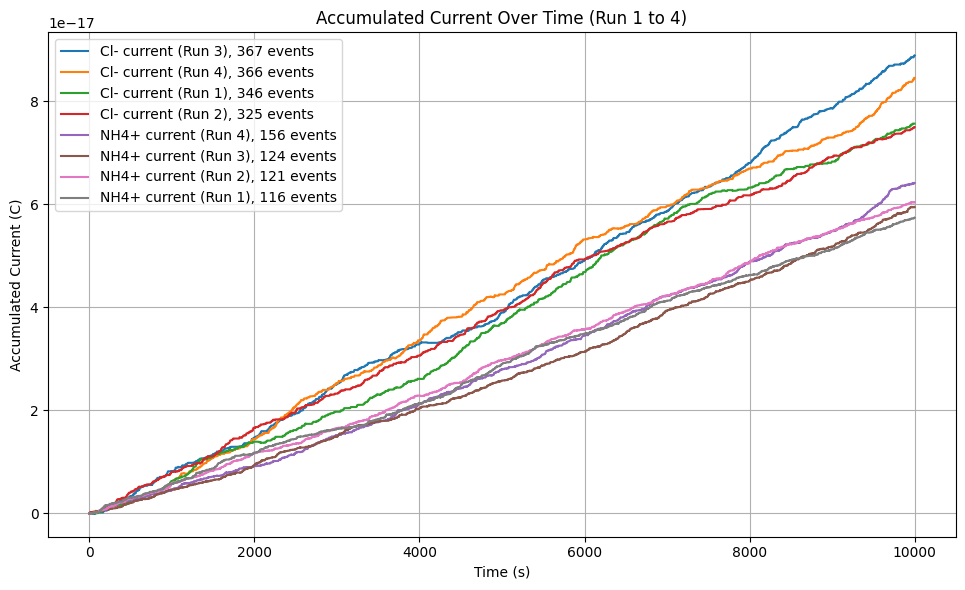

In [16]:
runs = ['run1', 'run2', 'run3', 'run4']
species = ['NH4-10', 'CLA-10']
plot_settings()

def load_currents(runs, species, dt):
    currents = {}
    for run in runs:
        for spec in species:
            data = np.loadtxt(f'{run}/current{spec}.dat')
            currents[f"{run}_{spec}"] = data[:, 1] * dt
    return currents

currents = load_currents(runs, species, dt)

labels = [
    ('run3_CLA-10', 'Cl- current (Run 3), 367 events'),
    ('run4_CLA-10', 'Cl- current (Run 4), 366 events'),
    ('run1_CLA-10', 'Cl- current (Run 1), 346 events'),
    ('run2_CLA-10', 'Cl- current (Run 2), 325 events'),
    ('run4_NH4-10', 'NH4+ current (Run 4), 156 events'),
    ('run3_NH4-10', 'NH4+ current (Run 3), 124 events'),
    ('run2_NH4-10', 'NH4+ current (Run 2), 121 events'),
    ('run1_NH4-10', 'NH4+ current (Run 1), 116 events')
]

for current_key, label in labels:
    plt.plot(currents[current_key], label=label)

plt.legend()
plt.show()

## NH4Cl vs NaCl Run 1

In [6]:
print("NH4Cl-----------------------------")
!cat run1/overallNH4-10.dat
!cat run1/overallCLA-10.dat
print("NaCl-----------------------------")
!cat /Users/heiley/Desktop/run1/NaCl/overallSOD-10.dat
!cat /Users/heiley/Desktop/run1/NaCl/overallCLA-10.dat

NH4Cl-----------------------------
116 NH4 crossed along +z direction
0 NH4 crossed along -z direction
0 CLA crossed along +z direction
346 CLA crossed along -z direction
NaCl-----------------------------
34 SOD crossed along +z direction
0 SOD crossed along -z direction
0 CLA crossed along +z direction
346 CLA crossed along -z direction


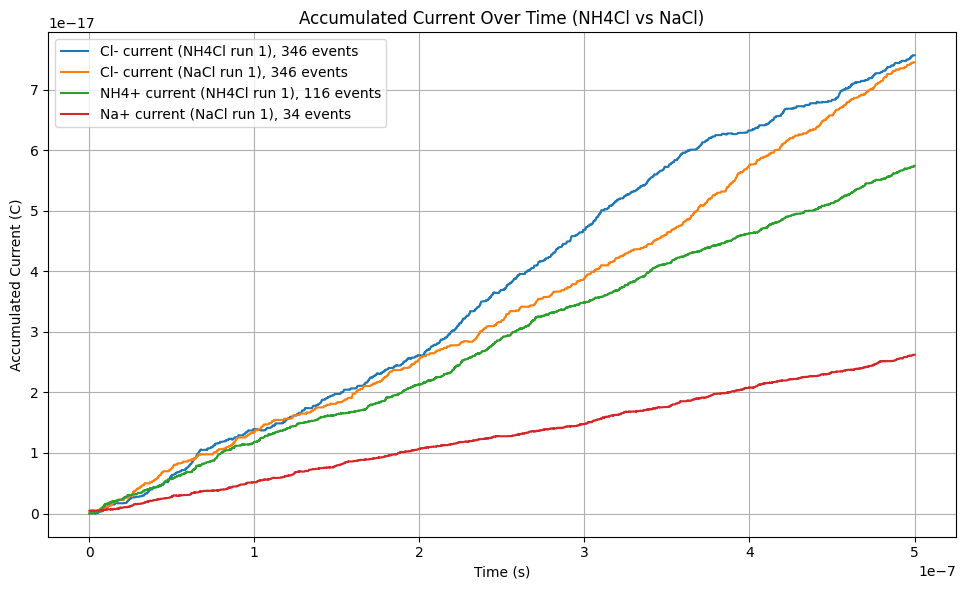

In [4]:
data3 = np.loadtxt('/Users/heiley/Desktop/run1/NaCl/currentSOD-10.dat')
time3 = data3[:, 0] * dt
current3 = data3[:, 1] * dt 

data4 = np.loadtxt('/Users/heiley/Desktop/run1/NaCl/currentCLA-10.dat')
time4 = data4[:, 0] * dt
current4 = data4[:, 1] * dt 

plot_settings()
plt.title("Accumulated Current Over Time (NH4Cl vs NaCl)")
plt.plot(time2, current2, label='Cl- current (NH4Cl run 1), 346 events')
plt.plot(time4, current4, label='Cl- current (NaCl run 1), 346 events')
plt.plot(time1, current1, label='NH4+ current (NH4Cl run 1), 116 events')
plt.plot(time3, current3, label='Na+ current (NaCl run 1), 34 events')
plt.legend()
plt.savefig('run1/run_combined_accumulated_current_plot.png')
plt.show()

# 3. RMSD
- It has a relatively high rmsd (4 A), compared to the normal 2 A.  

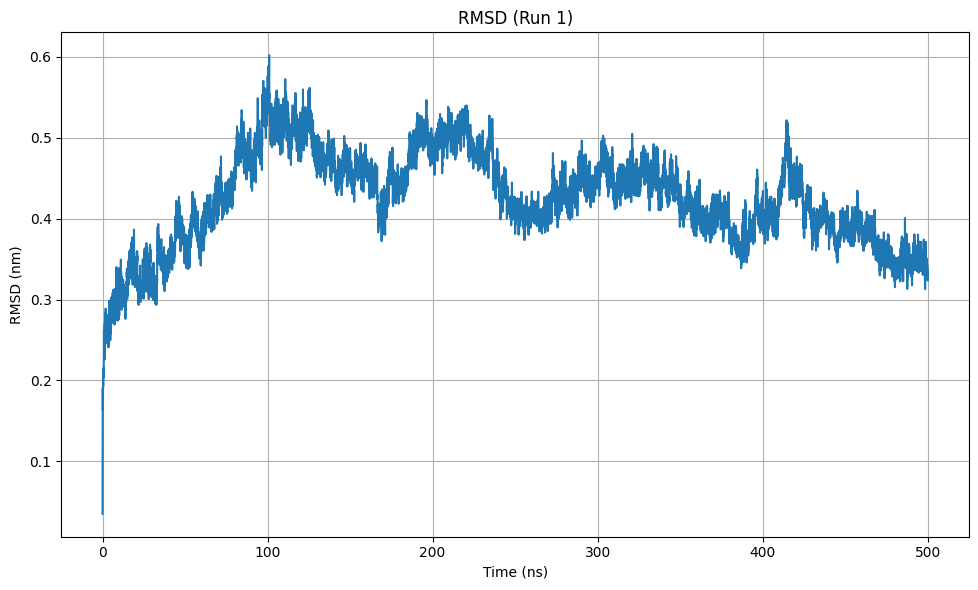

In [32]:
data7 = np.loadtxt('run1/rmsd-fit.xvg',skiprows=18)
time7 = data7[:, 0] 
rmsd = data7[:, 1] 

plot_settings()
plt.xlabel("Time (ns)")
plt.ylabel("RMSD (nm)")
plt.title("RMSD (Run 1)")
plt.plot(time7, rmsd)
plt.savefig('run1/rmsd.png')
plt.show()

# 4. RMSF
- The tail has a high RMSF (0.4 A)
- As the head is fixed, it has low RMSF

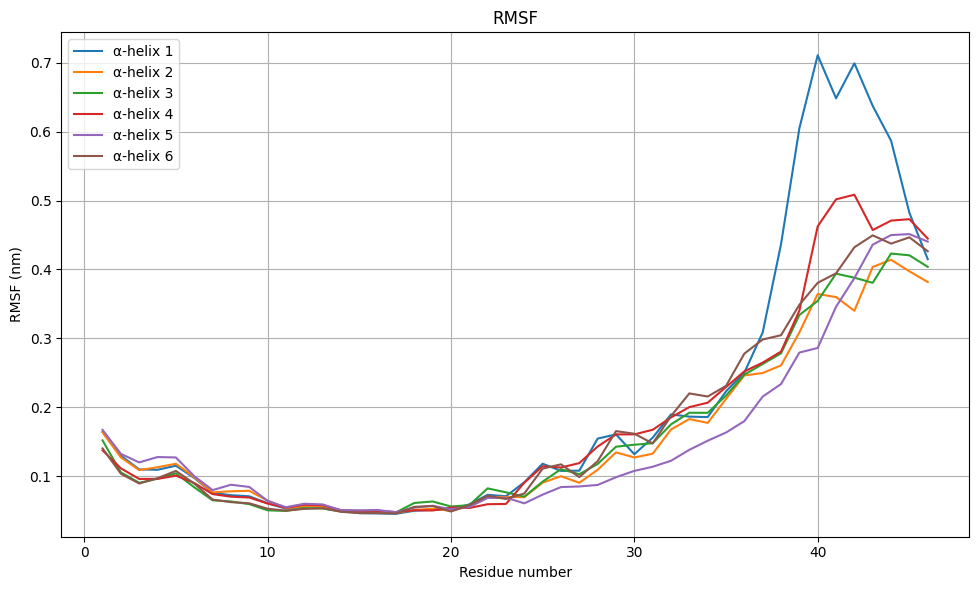

<Figure size 640x480 with 0 Axes>

In [44]:
data8 = np.loadtxt('run1/rmsf.xvg', skiprows=17)
plot_settings()
for i in range(0, len(data), 46):
    segment = data8[i:i+46]
    resno = segment[:, 0]
    rmsf = segment[:, 1]
    plt.plot(resno, rmsf, label=f'α-helix {i//46 + 1}')

plt.xlabel('Residue number')
plt.ylabel('RMSF (nm)')
plt.title('RMSF')
plt.legend()
plt.show()
plt.savefig('run1/rmsf.png')

# 5. Radius of gyration

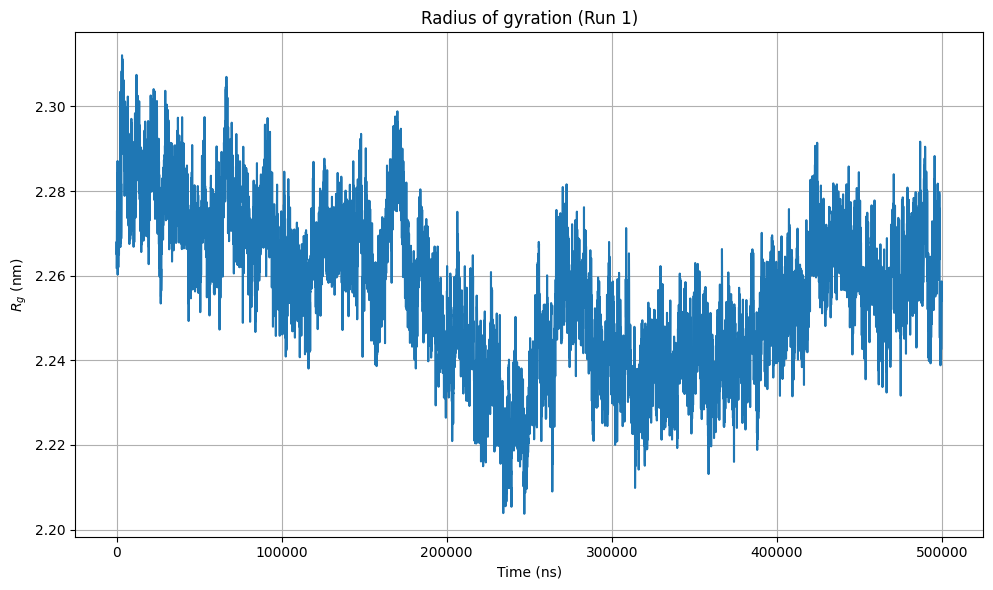

In [47]:
data9 = np.loadtxt('run1/gyrate.xvg',skiprows=27)
time9 = data9[:, 0] 
rg = data9[:, 1] 

plot_settings()
plt.xlabel("Time (ns)")
plt.ylabel("$R_g$ (nm)")
plt.title("Radius of gyration (Run 1)")
plt.plot(time9, rg)
plt.savefig('run1/rg.png')
plt.show()